# Reducing Network Latency & Anomaly Detection with Autoencoders

The goal of this project is twofold:
- Reduce the network traffic in the cloud from the gateway layer.
- Detect anomalous data, indicating a faulty sensor or a potential attack.

We use a subset of data collected from Intel Labs between March and April, 2004 (http://db.csail.mit.edu/labdata/labdata.html) as a proof of concept for applying Deep Learning at the IoT Gateway Layer.

Rather than sending data from the gateway to the cloud as values are received, we will attempt to batch incoming readings, and encode them into a smaller, learned representation. The advantage of doing this is that we can now apply anomaly detection techniques to a much smaller dimension vector representation.

## Data Loading

In [1]:
import gzip
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Dropout
from keras.models import Model

Using TensorFlow backend.


In [2]:
with gzip.open('data.txt.gz', 'rb') as data_bytes:
    data = pd.read_csv(data_bytes, header=None, sep=' ', parse_dates=[[0, 1]], squeeze=True)
data.columns = ['DATETIME','EPOCH','SENSOR_ID','TEMPERATURE','HUMIDITY','LIGHT','VOLTAGE']
data = data.set_index('DATETIME')

In [3]:
data.shape

(2313682, 6)

## Data Pre-processing

We will consider sensor data between March 1st and March 7th for this experiment, as it contains the majority of the complete data.

In [4]:
data_samp = data.loc['2004-03-01':'2004-03-7'].copy()
data_samp.shape

(652621, 6)

For the purposes of a proof of concept, we will make this a univariate problem (not including DateTime), focusing on Temperature readings.

In [5]:
data_samp.drop(['HUMIDITY','LIGHT','VOLTAGE','EPOCH'], axis=1, inplace=True)

Dropping any Sensor ID's where the value is NaN.

In [6]:
data_samp.dropna(subset=['SENSOR_ID'], inplace=True)

For the sake of our experiment, let us only consider sensors 1-10.

In [7]:
data_samp = data_samp[(data_samp.SENSOR_ID >= 1) & (data_samp.SENSOR_ID <= 10)]

Reshaping the Sensor ID field to an integer value.

In [8]:
data_samp.SENSOR_ID.unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [9]:
data_samp.SENSOR_ID = data_samp.SENSOR_ID.astype(int)
data_samp.dtypes

SENSOR_ID        int64
TEMPERATURE    float64
dtype: object

In [10]:
data_samp.head()

,SENSOR_ID,TEMPERATURE
DATETIME,,
2004-03-01 00:01:57.130850,1,18.4498
2004-03-01 00:02:50.458234,1,18.4400
2004-03-01 00:04:26.606602,1,18.4400
2004-03-01 00:05:28.379208,1,18.4498
2004-03-01 00:05:50.456126,1,18.4302


We want to measure the temperature at each sensor for a given timestamp, so we will pivot the table, making the column values sensor temperature readings at a given timestamp.

In [11]:
data_samp = data_samp.pivot(columns='SENSOR_ID', values='TEMPERATURE')

In [12]:
data_samp.head()

SENSOR_ID,1,2,3,4,5,6,7,8,9,10
DATETIME,,,,,,,,,,
2004-03-01 00:00:21.445722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.489,NaN
2004-03-01 00:00:22.429139,NaN,18.8712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-01 00:00:25.633782,NaN,NaN,NaN,NaN,NaN,NaN,18.7144,NaN,NaN,NaN
2004-03-01 00:00:52.381230,NaN,18.8614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-01 00:00:53.317719,NaN,NaN,NaN,NaN,NaN,NaN,18.7046,NaN,NaN,NaN


There are a lot of missing values for temperature readings in our table, due to micro-second DateTime ID's in our time-series set. We will resample the data every minute, taking the mean of the values collected. 

In a real-world setting this could be a batched process or queue of incoming data over a time interval.

In [13]:
data_samp = data_samp.resample('1min').mean()

In [14]:
print('New resampled set has: {} data points.'.format(len(data_samp)))
data_samp.isna().sum()

New resampled set has: 10080 data points.


SENSOR_ID
1      1366
2      3069
3      1400
4      2322
5     10080
6      2954
7       475
8      3332
9       955
10     1452
dtype: int64

Clearly sensor 5 is not reading values between our time frame, and sensor 8 is missing a significant portion of it's data to attempt reconstruction, so we will drop it. 

Stack brings the prescribed column (SENSOR_ID) into our index, making it easily dropped. We unstack to bring Sensor ID out of the index.

In [15]:
temp_df = data_samp.stack().drop([5, 8], level='SENSOR_ID')
data_samp = temp_df.unstack()

In [16]:
data_samp

SENSOR_ID,2,6,7,9,1,3,4,10
DATETIME,,,,,,,,
2004-03-01 00:00:00,18.8663,18.6752,18.7095,18.489000,NaN,NaN,NaN,NaN
2004-03-01 00:01:00,18.8614,18.6752,18.7046,18.482467,18.4498,18.7536,19.1113,18.4302
2004-03-01 00:02:00,18.8614,18.6654,18.6948,18.469400,18.4400,18.7634,19.1064,NaN
2004-03-01 00:03:00,18.8418,18.6654,18.6899,NaN,NaN,18.7536,19.1064,NaN
2004-03-01 00:04:00,18.8320,18.6654,18.6850,18.479200,18.4400,18.7340,19.1113,18.4106
...,...,...,...,...,...,...,...,...
2004-03-07 23:55:00,22.9284,22.4776,22.4923,22.056200,22.6834,22.7716,22.8598,21.9582
2004-03-07 23:56:00,22.9088,22.4678,22.4972,22.061100,22.6736,22.7716,22.8500,21.9533
2004-03-07 23:57:00,22.9088,22.4678,22.4923,22.041500,22.6785,22.7618,22.8549,21.9484


There are still some missing values, which we can simply deal with by applying linear interpolation to estimate values making our set continuous. Interpolation uses previous values, so for values appearing at the front of our frame (ie. sensor 1) we must make the process bidirectional.

We interpolate at the row level, since readings between close by sensors at a give time will be more indicitive of true temperature than minute to minute guesses on the same sensor.

In [17]:
data_samp = data_samp.interpolate(method='spline', order=2, limit_direction='both', axis=0)

In [18]:
data_samp.isna().sum()

SENSOR_ID
2     0
6     0
7     0
9     0
1     0
3     0
4     0
10    0
dtype: int64

In [19]:
data_samp.describe()

SENSOR_ID,2,6,7,9,1,3,4,10
count,10080.000000,10080.000000,10080.000000,10080.000000,10080.000000,10080.000000,10080.000000,10080.000000
mean,21.957166,21.629939,21.714271,21.615788,22.139674,22.130016,22.128592,21.393151
std,2.000003,1.957363,2.150584,2.438546,2.679119,2.395939,2.195915,2.134782
min,17.641300,17.216932,17.776867,17.471980,17.195400,17.504506,18.028400,17.122464
25%,20.601647,20.131858,19.988400,19.557200,19.973700,20.233400,20.496814,19.674800
50%,21.905117,21.570492,21.589883,21.419200,21.811200,21.932518,21.860200,21.321200
75%,23.222400,23.095000,23.340817,23.320400,24.222000,23.949556,23.517625,22.987200
max,27.416800,26.534800,26.427000,27.171800,28.681000,28.269400,27.652000,25.819400


Now our data set smoothly tracks Temperature over 1 minute intervals without undefined data points. Let's plot our findings for each sensor in our dataframe.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a3afe30d0>,
      dtype=object)

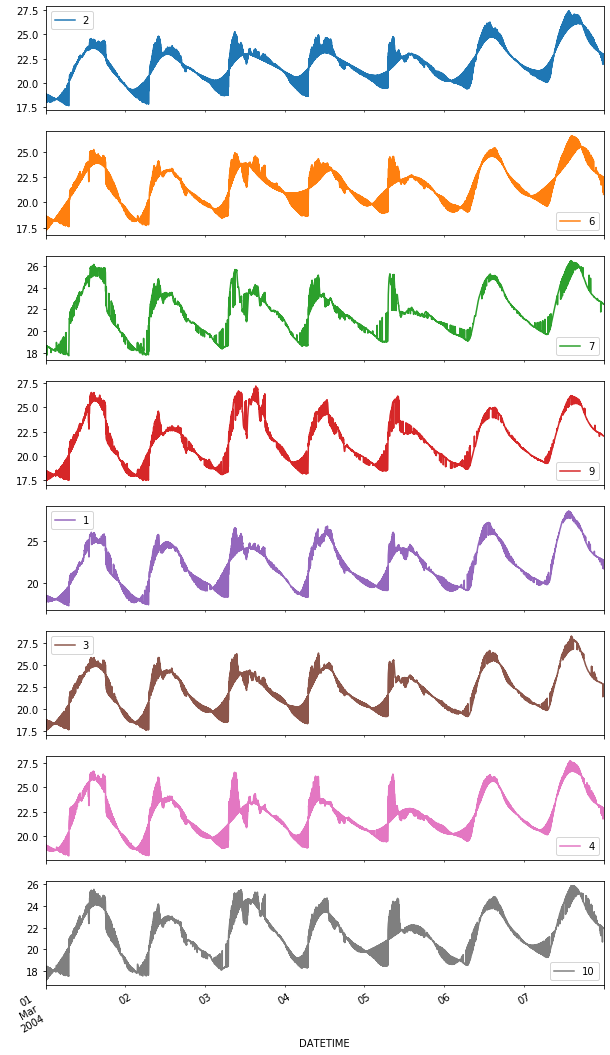

In [20]:
data_samp.plot(subplots=True, legend=True, figsize=(10,20))

## Autoencoder

We have collected our time-series data as a vector $\vec{T}$, where $\vec{T}$ contains all of the time samples for each sensor value. This can be represented as:

$\vec{T}=\lbrace\langle s_1\cdots s_n\rangle|s_k\in S, 1\leq k\leq n\rbrace$, where $S$ is the set of sensors transmitting to the gateway.

We choose to use an autoencoder for several reasons:

    1. Responds well to seasonal data fluctuation
    2. Sending the decoder to the cloud is a one-time operation
    3. Trains quickly
    4. Easy to understand, compared to other network models (CNNs, or time-series variants)

The goal of the autoencoder is to send a _representation_ of the input batch that is smaller in size (less bytes) but can be decoded to reveal the same information. Using our time-series data, we will generate a training set that mimics a batch over a windowed time period.

![AE](./img/ae.png)

Our autoencoder input will be an arbitrarily chosen length, with $n$ dimensions for each input. We will iteratively train the encoder in an attempt to reconstruct the original vectors (as close as possible). Once we have a reasonable reconstruction, we can send the yellow nodes to the cloud. Incoming data will be encoded (seen in red) and sent to the cloud as a smaller representation. Let us begin by choosing a window size for batched time samples.

### Data Preparation

In [21]:
window = 3

We will turn this time-series problem into a cross-sectional problem by taking a sliding window of vectors and applying the result to a standard autoencoder. First, let us drop values to make our window compatible with an autoencoder input.

In [22]:
# Effectively dropping the last data_samp[0] mod <window> values.
data_window = data_samp[:math.floor(data_samp.shape[0]/window)*window]
data_window

SENSOR_ID,2,6,7,9,1,3,4,10
DATETIME,,,,,,,,
2004-03-01 00:00:00,18.8663,18.675200,18.7095,18.489000,17.698805,17.504506,18.729463,17.122464
2004-03-01 00:01:00,18.8614,18.675200,18.7046,18.482467,18.449800,18.753600,19.111300,18.430200
2004-03-01 00:02:00,18.8614,18.665400,18.6948,18.469400,18.440000,18.763400,19.106400,17.134191
2004-03-01 00:03:00,18.8418,18.665400,18.6899,17.471980,17.697222,18.753600,19.106400,17.140065
2004-03-01 00:04:00,18.8320,18.665400,18.6850,18.479200,18.440000,18.734000,19.111300,18.410600
...,...,...,...,...,...,...,...,...
2004-03-07 23:55:00,22.9284,22.477600,22.4923,22.056200,22.683400,22.771600,22.859800,21.958200
2004-03-07 23:56:00,22.9088,22.467800,22.4972,22.061100,22.673600,22.771600,22.850000,21.953300
2004-03-07 23:57:00,22.9088,22.467800,22.4923,22.041500,22.678500,22.761800,22.854900,21.948400


The new data window size will guarantee the autoencoder input will be consistent. Now we will define a function to create a sliding window over each timestep, looking like: $\lbrack t_0, t_1, t_2\rbrack, \lbrack t_1, t_2, t_3\rbrack,\cdots,\lbrack t_{n-2}, t_{n-1}, t_n\rbrack$

In [23]:
def build_window(arr, window):
    iterator = iter(arr)
    n_windows = len(arr)-window+1
    for i in range(n_windows):
        yield arr[i:i+window]

In [24]:
data_window_slide = list(build_window(data_samp.values, window))

Now our data is in a sliding window of 3 vectors with 9 sensor dimensions. We would like to concatenate the vectors in each windowed batch:

In [25]:
for i in range(len(data_window_slide)):
    data_window_slide[i] = data_window_slide[i].flatten()

In [26]:
data_window_slide[0:3]

[array([18.8663    , 18.6752    , 18.7095    , 18.489     , 17.69880463,
        17.50450605, 18.72946268, 17.12246413, 18.8614    , 18.6752    ,
        18.7046    , 18.48246667, 18.4498    , 18.7536    , 19.1113    ,
        18.4302    , 18.8614    , 18.6654    , 18.6948    , 18.4694    ,
        18.44      , 18.7634    , 19.1064    , 17.13419089]),
 array([18.8614    , 18.6752    , 18.7046    , 18.48246667, 18.4498    ,
        18.7536    , 19.1113    , 18.4302    , 18.8614    , 18.6654    ,
        18.6948    , 18.4694    , 18.44      , 18.7634    , 19.1064    ,
        17.13419089, 18.8418    , 18.6654    , 18.6899    , 17.47197961,
        17.69722214, 18.7536    , 19.1064    , 17.1400651 ]),
 array([18.8614    , 18.6654    , 18.6948    , 18.4694    , 18.44      ,
        18.7634    , 19.1064    , 17.13419089, 18.8418    , 18.6654    ,
        18.6899    , 17.47197961, 17.69722214, 18.7536    , 19.1064    ,
        17.1400651 , 18.832     , 18.6654    , 18.685     , 18.4792    ,


In [27]:
data_window_slide[0].shape

(24,)

The advantage of taking the time component out is that we are able to randomize our training representations. Each $n\times k$ value (where $k$ is the window size, and $n$ is the dimensionality) describes a feature of the graph above, but is still a learnable representation in any order. This makes the encoding more robust to seasonal changes, although they are not represented in the data.

In order to prevent gradients from vanishing, we need to normalize our data, so we will fit our data to values in the range $\lbrack0,1\rbrack$. To accomplish this we can use the following formula:

$\text{norm($x_i$)}=\frac{x_i-\text{min($x$)}}{\text{max($x$)}-\text{min($x$)}}$.

In [28]:
data_window_arr = np.array(data_window_slide)

First, we convert the list into an array of np.array's. Using the normalize function below, we normalize the data set.

In [29]:
def normalize(data: list):
    min_x = data.min()
    max_x = data.max()
    denom = max_x - min_x
    return (data-min_x) / denom

In [30]:
data_window_norm = normalize(data_window_arr)

In [31]:
data_window_norm[0:3]

array([[0.15086996, 0.13433673, 0.13730423, 0.11822742, 0.04986276,
        0.0330528 , 0.13903132, 0.        , 0.15044603, 0.13433673,
        0.1368803 , 0.11766218, 0.11483599, 0.14111959, 0.17206642,
        0.11314027, 0.15044603, 0.13348887, 0.13603244, 0.1165317 ,
        0.11398813, 0.14196745, 0.17164249, 0.00101455],
       [0.15044603, 0.13433673, 0.1368803 , 0.11766218, 0.11483599,
        0.14111959, 0.17206642, 0.11314027, 0.15044603, 0.13348887,
        0.13603244, 0.1165317 , 0.11398813, 0.14196745, 0.17164249,
        0.00101455, 0.14875032, 0.13348887, 0.13560851, 0.03023873,
        0.04972585, 0.14111959, 0.17164249, 0.00152277],
       [0.15044603, 0.13348887, 0.13603244, 0.1165317 , 0.11398813,
        0.14196745, 0.17164249, 0.00101455, 0.14875032, 0.13348887,
        0.13560851, 0.03023873, 0.04972585, 0.14111959, 0.17164249,
        0.00152277, 0.14790246, 0.13348887, 0.13518458, 0.11737956,
        0.11398813, 0.13942388, 0.17206642, 0.11144455]])

### Data Splitting

Splitting the dataset into train/test sets. By default, the training/test split will be 90/10

In [32]:
def split_data(data, test_size=0.1):
    X_train, X_test = train_test_split(data, test_size=test_size)
    return X_train, X_test

In [33]:
train, test = split_data(data_window_norm)

In [34]:
print('Train size: {}, Test size: {}'.format(len(train), len(test)))

Train size: 9070, Test size: 1008


We will now define the model:

In [35]:
n_features = len(data_window_norm[0])
encoding_dim = 6
hidden_dim = 16

input_layer = Input(shape=(n_features,))
dropout_1 = Dropout(rate=0.1)(input_layer)
hidden_1 = Dense(hidden_dim, activation='relu')(dropout_1)
encoded = Dense(encoding_dim, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_dim, activation='relu')(encoded)
output_layer = Dense(n_features, activation='relu')(hidden_2)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

In [36]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                400       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 102       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                112       
_________________________________________________________________
dense_4 (Dense)              (None, 24)                408       
Total params: 1,022
Trainable params: 1,022
Non-trainable params: 0
_________________________________________________________

Since this is a regression problem, we choose the Mean-squared Error (MSE) objective function. This is the function we will minimize through gradient descent. MSE is a measure of the average squared distance between estimated and actual values.

Adam appears to be the optimizer of choice; It converges the fastest of any Keras-implemented optimizer (for most data sets), and with a default learning rate of 0.001 it is unikely to miss any features when updating gradients.

For the hidden layer, we chose ReLU as an activation function, since it handles the vanishing gradient problem well (ie. unlike sigmoid, it does not flatten at 0). For the output layer, we use the ReLU function as well.

The number of parameters are calculated by looking at the input shape, multiplied by the size of the next layer, plus the number of bias nodes. Bias nodes are used to help the network fit data in the case of all the input features are 0, hence no gradient can be calculated. 

For the case of Input Layer into the encoded Dense layer, we have 24 nodes, mapping to a hidden layer of 16, with 16 bias nodes connected to the encoded layer, $24\times16+16=400$.

Given our autoencoder, let's fit it. Note the target of the autoencoder is the training data as well, so the input is supplied as the target. The testing set will be used for validation.

In [37]:
history = autoencoder.fit(train, train,
    epochs=20,
    batch_size=10,
    validation_data=(test, test),
    shuffle=True
)

Train on 9070 samples, validate on 1008 samples
Epoch 1/20
9070/9070 [==============================] - 2s 226us/step - loss: 0.0859 - val_loss: 0.0794
Epoch 2/20
9070/9070 [==============================] - 2s 187us/step - loss: 0.0750 - val_loss: 0.0730
Epoch 3/20
9070/9070 [==============================] - 2s 191us/step - loss: 0.0735 - val_loss: 0.0730
Epoch 4/20
9070/9070 [==============================] - 2s 194us/step - loss: 0.0527 - val_loss: 0.0387
Epoch 5/20
9070/9070 [==============================] - 2s 191us/step - loss: 0.0244 - val_loss: 0.0131
Epoch 6/20
9070/9070 [==============================] - 2s 193us/step - loss: 0.0127 - val_loss: 0.0131
Epoch 7/20
9070/9070 [==============================] - 2s 271us/step - loss: 0.0126 - val_loss: 0.0136
Epoch 8/20
9070/9070 [==============================] - 3s 307us/step - loss: 0.0126 - val_loss: 0.0140
Epoch 9/20
9070/9070 [==============================] - 3s 276us/step - loss: 0.0126 - val_loss: 0.0135
Epoch 10/20
9070

Plotting the results:

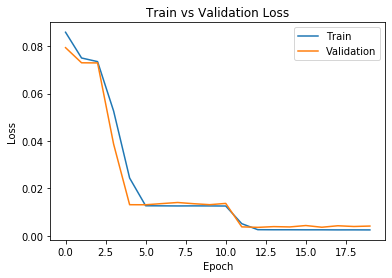

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

After about 11 epochs our training loss and validation loss appear to stabilize. We see the validation loss lagging behind the training loss at points due to the fact that validation loss does not include regularization loss, so ideally the validation plot would be shifted over. The fact that training loss $\approx$ validation loss could be a sign of underfitting the data. This could be remedied by resampling at a faster rate, performing more intelligent interpolation, or creating a deeper model with more neurons.

In previous trials, without using a deep autoencoder, I found that the model would underfit the data, or fail to perform on the training set due to lack of neurons. This loss curve is not ideal, and suggests we are overfitting, but decreasing the number of parameters leads to underfitting.

### Anomaly Detection

Using our encoding layer of the trained model, we can now generate compressed representations of our input batches. As mentioned above, this is powerful not only because of it's compression, but we can detect if a value is anomalous.

By learning to replicate the highest variation features in the training data, the model can learn how to reproduce the most frequent characteristics of the observations. Given an anomaly, the model should worsen its reconstruction performance. 

Reconstruction error (MSE) of a data point, or the error between the original data point and its encoding, is used to calculate the anomaly score.

First let us grab the encoder/decoder layer from the trained model:

In [39]:
encoder = Model(input_layer, encoded)

In [40]:
encoded_input = Input(shape=(encoding_dim,))
# retrieve the decoder layer of the autoencoder model
decoder_layer_1 = autoencoder.layers[-2]
decoder_layer_2 = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer_2(decoder_layer_1(encoded_input)))

Let's find a representation of an input vector (3 timestamps, each with 9 sensor dimensions)

In [41]:
sample_test = test[100:101]
sample_test

array([[0.33824664, 0.30475623, 0.29966909, 0.27126583, 0.3085716 ,
        0.32128947, 0.33697485, 0.27847263, 0.33782271, 0.30560409,
        0.29882123, 0.27253762, 0.30645195, 0.32086554, 0.33612699,
        0.27847263, 0.33612699, 0.30475623, 0.30051694, 0.27168976,
        0.30645195, 0.27819138, 0.33443127, 0.27847263]])

In [42]:
encoded_test = encoder.predict(sample_test)

In [43]:
reconstructed = decoder.predict(encoded_test)
reconstructed

array([[0.31793088, 0.2755904 , 0.2723632 , 0.23608893, 0.26703122,
        0.28922725, 0.30731118, 0.23917231, 0.32168457, 0.28130543,
        0.27108848, 0.23196314, 0.26822272, 0.29023027, 0.30659106,
        0.24122056, 0.31864512, 0.27794048, 0.26926923, 0.23340245,
        0.2674284 , 0.28826475, 0.3034975 , 0.23906878]], dtype=float32)

Now, let's introduce an anomalous reading to a sensor in a random position.

In [44]:
random_test = test
random_test[0][random.randint(0,len(random_test[0])-1)] = 0.99

In [45]:
random_test[0]

array([0.16655534, 0.14366317, 0.14281531, 0.07140807, 0.12868434,
       0.14988079, 0.17672964, 0.11017277, 0.16655534, 0.14239138,
       0.14140221, 0.99      , 0.12840172, 0.14959817, 0.17672964,
       0.1063574 , 0.16570748, 0.14281531, 0.14111959, 0.10974884,
       0.12840172, 0.14535888, 0.1444574 , 0.1091836 ])

Value of 0.99 is in the array, which will overshadow the smaller dimensions.

In [46]:
random_encoded_test = encoder.predict(random_test[0:1])
random_encoded_test

array([[0.        , 0.        , 0.43330833, 0.        , 0.23136383,
        0.11150733]], dtype=float32)

In [47]:
random_reconstructed = decoder.predict(random_encoded_test)
random_reconstructed

array([[0.2442038 , 0.20867433, 0.17903203, 0.16694704, 0.20341665,
        0.2010685 , 0.2447666 , 0.18289757, 0.24849245, 0.22206672,
        0.21039666, 0.1760722 , 0.21299535, 0.20985767, 0.2558973 ,
        0.15085147, 0.24254161, 0.26347345, 0.21332687, 0.18181841,
        0.21904278, 0.23856479, 0.24943599, 0.1777417 ]], dtype=float32)

Comparing the normal encoding to the anomalous one:

In [48]:
encoded_test[0]

array([0.        , 0.        , 0.57471514, 0.        , 0.02097753,
       0.        ], dtype=float32)

In [49]:
for i in range(len(encoded_test[0])):
    print('Value {} difference: |{}-{}|={}\n'.format(i, encoded_test[0][i], 
                                                     random_encoded_test[0][i], 
                                                     abs(encoded_test[0][i]-random_encoded_test[0][i])))

Value 0 difference: |0.0-0.0|=0.0

Value 1 difference: |0.0-0.0|=0.0

Value 2 difference: |0.5747151374816895-0.43330833315849304|=0.1414068043231964

Value 3 difference: |0.0-0.0|=0.0

Value 4 difference: |0.020977526903152466-0.23136383295059204|=0.21038630604743958

Value 5 difference: |0.0-0.11150732636451721|=0.11150732636451721



Given this compressed form, we can use other methods, like calculating the number of standard deviations from a mean reading to determine anomalous data points.

## LSTM Encoder-Decoder (Future Work)

Given an array of 9 sensor values with readings at every 2 minute interval, we would like to generate a compressed representation of these values, like the section above.

Let us consider the same vector $\vec{T}$ as our sensors temperature representation, but this time as time-series set.

Using the scale from $x_1\cdots x_{Tx}$ as a batch, we could choose a size similar to our sliding window in the previous concept.

This approach is different from above in that it offers a key capability: *prediction*. Using the LSTM approach, we will be able to predict values, and potentially send predictions to the cloud before readings are made. If an anomaly is detected in our actual readings we can update the cloud data, but in the average case this will outperform a traditional gateway. Of course, there are trade-offs to this approach. The upside is there will be no need to send the decoder to the cloud, since we can send batches of predicted values instead. The downside is the performance, and time to train is high.



![AUTOENCODER](./img/autoencoder.png)